# Change electricity marginal mixes

This example wurst project changes the marginal mixes of electricity in the ecoinvent consequential system model.

## Load ecoinvent

This notebook assumes that you have ecoinvent 3.3, consequential system model, installed. Adjust as needed.

In [1]:
import brightway2 as bw

In [2]:
ECOINVENT_DB_NAME = 'ecoinvent 3.3 consequential'

assert ECOINVENT_DB_NAME in bw.databases
assert len(bw.Database(ECOINVENT_DB_NAME))

Load the data from ecoinvent.

In [3]:
import wurst as w

In [4]:
ecoinvent = w.extract_brightway2_databases([ECOINVENT_DB_NAME])

Getting activity data


  1%|          | 2750/369171 [00:00<00:13, 27497.53it/s]

Adding exchange data to activities


  0%|          | 40/12321 [00:00<00:30, 398.12it/s]

Filling out exchange data


100%|██████████| 12321/12321 [00:01<00:00, 8285.84it/s]


## Load and clean input data

First load data from example input data sheet. You may need to install `xlrd`:

    !conda install -y openpyxl

In [5]:
import openpyxl

In [6]:
from openpyxl import load_workbook
wb = load_workbook(filename="data/consequential-mixes.xlsx")
ws = wb['data']

/Users/cmutel/miniconda3/envs/wurst/lib/python3.6/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Get regions codes

In [7]:
REGIONS = [(row, ws.cell(row=row, column=2).value) for row in range(5, 46)]

Define what column labels we will use.

In [8]:
PRODUCERS = {
    'electricity production, hard coal',
    'electricity production, lignite',
    'electricity production, natural gas, combined cycle power plant',
    'electricity production, oil',
    'electricity production, nuclear, pressure water reactor',
    'electricity production, hydro, reservoir, alpine region',
    'electricity production, hydro, reservoir, non-alpine region',
    'electricity production, hydro, reservoir, tropical region',
    'electricity production, hydro, run-of-river',
    'electricity production, wind, >3MW turbine, onshore',
    'electricity production, wind, 1-3MW turbine, offshore',
    'electricity production, deep geothermal',
    'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014',
    'electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted',
    'electricity production, photovoltaic, 570kWp open ground installation, multi-Si',
    'CSP solar tower',
    'CSP parabolic trough',
}

In [9]:
COLUMNS = [(col, ws.cell(row=4, column=col).value) for col in range(6, 27)
           if ws.cell(row=4, column=col).value in PRODUCERS]

In [10]:
data = {region: {tech: ws.cell(row=row_index, column=col_index).value 
                 for col_index, tech in COLUMNS
                 if ws.cell(row=row_index, column=col_index).value}
        for row_index, region in REGIONS
        if region != 'WO'}

Our `data` now looks like this:

	{
        'AT': {
            'electricity production, hydro, reservoir, alpine region': 885.851278194835,
            'electricity production, hydro, run-of-river': 2657.5538345845052,
            'electricity production, natural gas, combined cycle power plant': 7815.445475981833,
            'electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted': 2440.7354672168003,
            'electricity production, wind, >3MW turbine, onshore': 6091.564235280648,
            'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014': 1468.685036019685},
            'AU': {'electricity production, hard coal': 2299.4193831589578,
            'electricity production, natural gas, combined cycle power plant': 8258.07173127728,
            'electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted': 39623.643762789485,
            'electricity production, photovoltaic, 570kWp open ground installation, multi-Si': 20683.484469207007,
            'electricity production, wind, >3MW turbine, onshore': 5034.074334501579
        },
    }

Clean production technologies which are not in the current imported version of ecoinvent.

In [11]:
def remove_missing(dct, lst):
    return {k: v for k, v in dct.items() if k in lst}

ecoinvent_names = {x['name'] for x in ecoinvent}

data = {k: remove_missing(v, ecoinvent_names) for k, v in data.items()}

Need to normalize values to sum to one for each country.

In [12]:
def normalize(dct):
    total = sum(dct.values())
    return {k: v / total for k, v in dct.items()}

data = {k: normalize(v) for k, v in data.items()}

## Adjust ecoinvent electricity production mixes

We will put all generators into the high voltage mix, as this is the most widely used. The medium & low voltage will draw completely from high voltage. `wurst` already has a convenience function for this transformation.

In [13]:
from wurst.ecoinvent.electricity_markets import (
    empty_low_voltage_markets,
    empty_medium_voltage_markets,
    empty_high_voltage_markets,
)

In [14]:
empty_low_voltage_markets(ecoinvent)
empty_medium_voltage_markets(ecoinvent)

pass

Also need to empty out the high voltage market - we will fill this with our input data.

In [15]:
empty_high_voltage_markets(ecoinvent)

pass

## Add marginal electricity providers

Add marginal electricity providers to high voltage mixes. Need to select location-correct generation technologies for each region - sometimes a country-specific generator is not available.

In [16]:
from wurst.ecoinvent import ECOINVENT_ORDERED_GEO

We have to be a bit tricky with getting the right locations. We have many mixes in ecoinvent which don't correspond to regions in the input data. Some of these we can match directly, as shown below, e.g Canadian provinces get national candation stats. In cases where this doesn't work, such as Tanzania, we have to use the `RoW` input dataset.

In [17]:
REGION_MAPPING = {
    "ASCC": "US",
    "BA": "HR",  # Croatia for Bosnia & Herzegovina
    "CA-AB": "CA",
    "CA-BC": "CA",
    "CA-MB": "CA",
    "CA-NB": "CA",
    "CA-NF": "CA",
    "CA-NS": "CA",
    "CA-NT": "CA",
    "CA-NU": "CA",
    "CA-ON": "CA",
    "CA-PE": "CA",
    "CA-QC": "CA",
    "CA-SK": "CA",
    "CA-YK": "CA",
    "CSG": "CN",
    "FRCC": "US",
    "GB": "UK",
    "HICC": "US",
    "MK": "HR",  # Croatia for Macedonia
    "MRO, US only": "US",
    "NPCC, US only": "US",
    "RFC": "US",
    "RS": "HR", # Croatia for Serbia
    "SERC": "US",
    "SGCC": "CN",
    "SPP": "US",
    "TRE": "US",
    "WECC, US only": "US",
}

def get_input_location(location):
    if location in data:
        return location
    elif location in REGION_MAPPING:
        return REGION_MAPPING[location]
    else:
        return "RoW"

In [18]:
high_voltage_mixes = w.get_many(ecoinvent, w.equals('name', 'market for electricity, high voltage'))

In [19]:
for mix in high_voltage_mixes:
    providers = data[get_input_location(mix['location'])]

    for name, amount in providers.items():
        possible_matches = w.get_many(ecoinvent, w.equals('name', name))
        best_match = w.best_geo_match(possible_matches, ECOINVENT_ORDERED_GEO[mix['location']])
        if not best_match:
            assert mix['location'] in ('PL', 'EE')
            assert name == 'electricity production, wind, 1-3MW turbine, offshore'
            # 'electricity production, wind, 1-3MW turbine, offshore' doesn't have a RoW or GLO market
            # In this case we will use the offshore activity in Sweden (Could also use Finland, etc.)
            best_match = w.get_one(ecoinvent, w.equals('name', name), w.equals('location', 'SE'))

        mix['exchanges'].append({
            'amount': amount,
            'input': (best_match['database'], best_match['code']),
            'type': 'technosphere',
            'name': name,
            'location': best_match['location']
        })

## Write finished databases

In [26]:
NEW_DB_NAME = "ecoinvent 3.3 long-term"

In [20]:
w.write_brightway2_database(ecoinvent, NEW_DB_NAME)

12321 datasets
368693 exchanges
0 unlinked exchanges
  


Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:41


Title: Writing activities to SQLite3 database:
  Started: 07/06/2017 16:06:51
  Finished: 07/06/2017 16:07:33
  Total time elapsed: 00:00:41
  CPU %: 92.30
  Memory %: 6.34
Created database: ecoinvent 3.3 long-term


## Some simple meta-analysis

In [22]:
%matplotlib inline

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [30]:
gwp = ('IPCC 2013', 'climate change', 'GWP 100a')

In [31]:
lca = bw.LCA({bw.Database(ECOINVENT_DB_NAME).random(): 1}, gwp)
lca.lci()
lca.lcia()

old_results = {}

for act in tqdm(bw.Database(ECOINVENT_DB_NAME)):
    lca.redo_lcia({act: 1})
    old_results[act['code']] = lca.score

100%|██████████| 12321/12321 [01:38<00:00, 113.27it/s]


In [32]:
lca = bw.LCA({bw.Database(NEW_DB_NAME).random(): 1}, gwp)
lca.lci()
lca.lcia()

new_results = {}

for act in tqdm(bw.Database(NEW_DB_NAME)):
    lca.redo_lcia({act: 1})
    new_results[act['code']] = lca.score

100%|██████████| 12321/12321 [01:40<00:00, 122.29it/s]


In [40]:
differences = []

for key in old_results:
    if old_results[key] and new_results[key]:
        differences.append((new_results[key] - old_results[key]) / old_results[key])
        
differences = np.array(differences)
mask = (differences > -1) * (differences < 1)
differences = differences[mask]

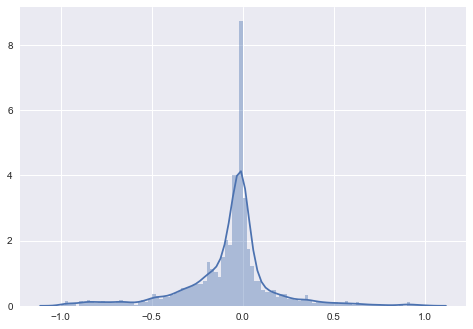

In [45]:
sns.distplot(differences, bins=100)